<a href="https://colab.research.google.com/github/gyana-ranjan-dash/airbnb-NYC/blob/main/Airbnb_Bookings_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  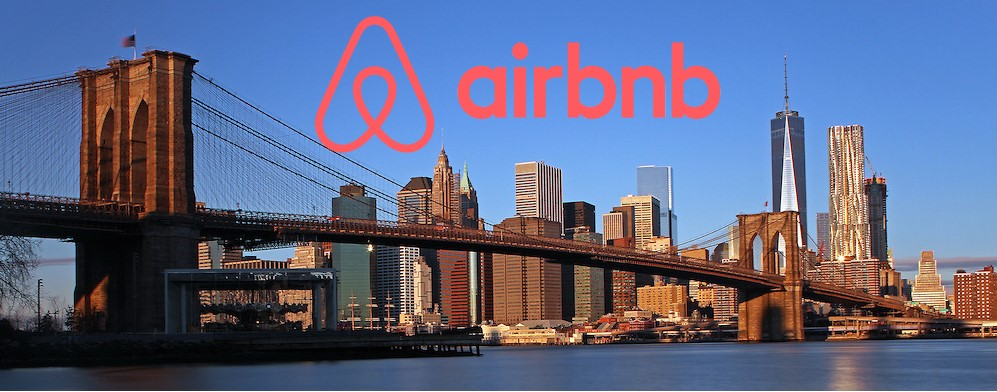

## **Introduction**

Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present a more unique, personalized way of experiencing the world. Today, Airbnb became one of a kind service that is used and recognized by the whole world.


In this project I tried to visualize the past data of 2018 and 2019 from Airbnb NYC and help the company to increase revenue and provide better service to the customers

In [1]:
pip install geopandas

     |████████████████████████████████| 1.0MB 13.3MB/s 
     |████████████████████████████████| 15.3MB 270kB/s 
     |████████████████████████████████| 6.5MB 52.9MB/s 


In [2]:
pip install geoplot

     |████████████████████████████████| 12.1MB 21.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.1MB 257kB/s 
     |████████████████████████████████| 225kB 16.9MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516165 sha256=1a3b2f01a376d5acb9795560f117966a80ae15d2dfd372d34c632ed0a66bf948
  Stored in directory: /root/.cache/pip/wheels/45/7f/3b/37879587817fd1bbbee7b47312e2401b4f542cccf2fbe9b4ee
Successfully built cartopy
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=0957527410daf49d388513a0267ad160a97871b370a2cfec84707919fcae1f6d
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built pyshp


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice
from shapely.geometry import polygon,point
from plotnine import *
from shapely.geometry import Point 
import geopandas as gpd
import geoplot
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

## **1-Reading and importing Data**


> import and read the airbnb dataset in ``airbnb_df`` 



In [5]:
#import data from csv file

airbnb_df = pd.read_csv("https://raw.githubusercontent.com/gyana-ranjan-dash/airbnb_2018/main/Copy%20of%20Airbnb%20NYC%202019.csv")

In [6]:
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Each column in the dataframe gives us information about the property.













*   The name of the property is set by the host
*   host_id and host_name are identification ids of the host for Airbnb


*   There are five groups in neighbourhood_group, shown above

*   The neighbourhood tells us which specific neighbourhood in the group the property belongs to

*   latitude and longitude give us the coordinates of the location. We can use this with folium to map all the locations
*   price will be the attribute we will try to predict


*   minimum_nights are the minimum number of nights the property has to be booked for


*   number_of_reviews, last_review, and reviews_per_month give us information about the reviews of each property.


*   calculated_host_listings_count and availability_365 are additional features that tell us how many total properties the host has, and how long this property is available in a year






In [7]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

**Initial insights from the above info check**


*   Few columns like ``last_review`` ``reviews_per_month``  contain high value of null values
*   All the data types seems fine



In [8]:
airbnb_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [58]:
print(airbnb_df['price'].describe(percentiles=[.25, .50, .75, .95]))

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
95%        355.000000
max      10000.000000
Name: price, dtype: float64


we find there are lot of outliers in the data, for better visualization we ignore the top 5% of data and  consider prices which are below $400

In [9]:
airbnb_df['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [10]:
len(airbnb_df['neighbourhood'].unique())

221

In [11]:
airbnb_df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

#### **Data Cleaning**

In [12]:
# checking for percentage of null values
airbnb_df.isnull().mean()*100

id                                 0.000000
name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64



--- The columns like ``last_review`` and ``reviews_per_month`` contains more than 20% of null values which needs to treated. 




--- For project the few columns are irrelevant such as ``name`` ``host_name`` and ``last_review`` 




--- For the column ``reviews_per_month`` we can impute the null values with 0



In [13]:
#checking for any duplicate values in the dataset
airbnb_df.duplicated().sum()

0

there are no duplicate values in the dataset

In [14]:
airbnb_df.drop(['id','name','last_review'],axis = 1, inplace = True)

In [15]:
airbnb_df.shape

(48895, 13)

After dropping the 3 columns we left with 13 columns and 48895 rows to work on.

In [16]:
# impute the null values as 0

airbnb_df['reviews_per_month'] = airbnb_df['reviews_per_month'].fillna(0)

In [17]:
airbnb_df.isnull().mean()*100

host_id                           0.000000
host_name                         0.042949
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

Afrer dropping the irrelevant columns and imputing 0 in place of ``NULL`` now we don't have any significant null values in our dataset

## **EDA**

Index(['host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

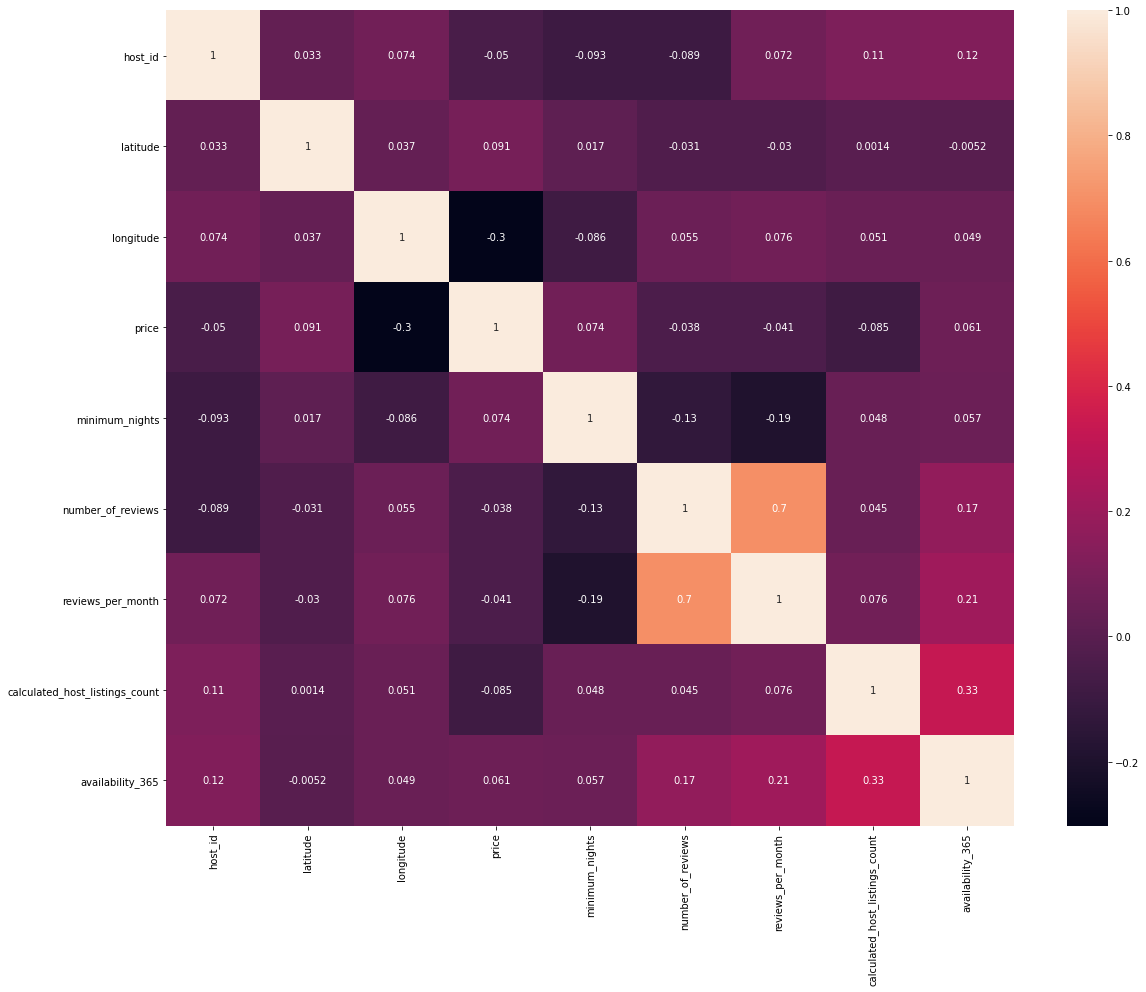

In [18]:
# checking for correlation between the variables
plt.figure(figsize=(19, 15))
corr_df=airbnb_df.corr(method='kendall')
sns.heatmap(corr_df, annot=True)
airbnb_df.columns


From the correlation matrix we can see there is a strong correlation between ``number of reviews`` and ``reviews per month``

In [19]:
# calculating total number of rooms for different room types

room_type_df = pd.DataFrame(airbnb_df['room_type'].value_counts()).reset_index().rename(columns = {"index":'room_type', 'room_type':'Total_listed_rooms'})

room_type_df

,room_type,Total_listed_rooms
0,Entire home/apt,25409
1,Private room,22326
2,Shared room,1160


<Figure size 720x360 with 0 Axes>

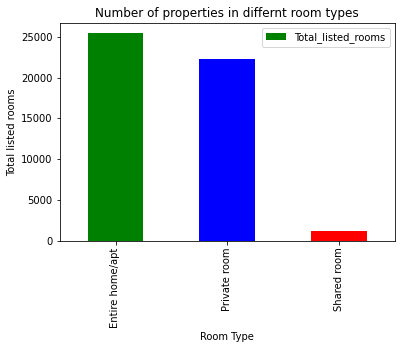

In [20]:
plt.figure(figsize=(10, 5))
my_colors = list(islice(cycle(['g', 'b', 'r']), None, len(room_type_df)))
room_type_df.plot.bar(x = 'room_type', y = 'Total_listed_rooms', color=my_colors)

plt.xlabel("Room Type")
plt.ylabel("Total listed rooms")
plt.title("Number of properties in differnt room types")
plt.show()

From the above bar plot we can clearly see that ``Entire home/apt`` is more highest in number where as the number of ``shared room`` is very less

In [21]:
airbnb_df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [22]:
neighbourhood_group_df = pd.DataFrame(airbnb_df['neighbourhood_group'].value_counts()).reset_index().rename(columns = {'index' : 'neighbourhood_group', 'neighbourhood_group':'Total_rooms_listed'})
neighbourhood_group_df

,neighbourhood_group,Total_rooms_listed
0,Manhattan,21661
1,Brooklyn,20104
2,Queens,5666
3,Bronx,1091
4,Staten Island,373


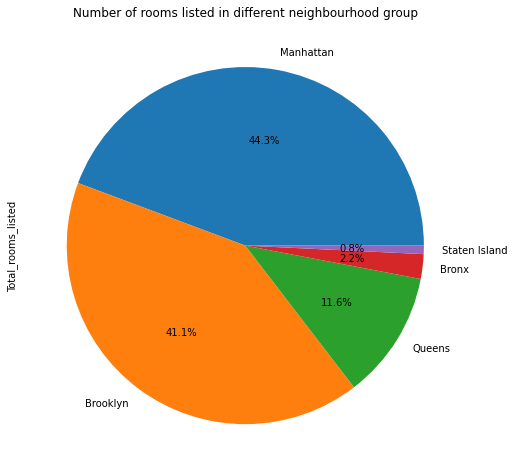

In [23]:
neighbourhood_group_df.plot.pie(y = 'Total_rooms_listed', autopct='%1.1f%%',labels= neighbourhood_group_df['neighbourhood_group'] ,legend = False,figsize=(8, 10))
plt.title("Number of rooms listed in different neighbourhood group")
plt.show()

**From the above pie chart the following instances we can conclude**

*   ``Manhattan`` and ``brooklyn`` have most number of rooms, together have more than 85% of total rooms available
*   ``manhattan`` has highest number of rooms which is more than 44%



In [24]:

top_10_host = pd.DataFrame(airbnb_df['host_id'].value_counts()).reset_index().rename(columns = {'index':"host_id", 'host_id':'Number of listed apt'}).head(10)

Stored the list of top 10 host in a separate dataframe ``top_10_host`` . This dataFrame contains top 10  list of ``host_id`` and total number of properties by that host listed on . 

In [25]:
top_10_host

,host_id,Number of listed apt
0,219517861,327
1,107434423,232
2,30283594,121
3,137358866,103
4,12243051,96
5,16098958,96
6,61391963,91
7,22541573,87
8,200380610,65
9,7503643,52


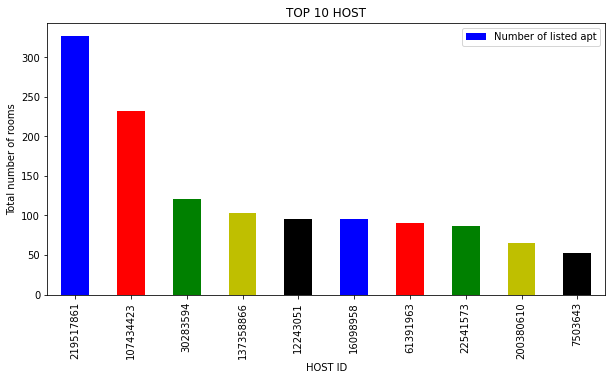

In [26]:
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(top_10_host)))
top_10_host.plot.bar(x ='host_id', y = 'Number of listed apt', color =my_colors, figsize = (10,5))
plt.xlabel("HOST ID")
plt.ylabel("Total number of rooms")
plt.title("TOP 10 HOST")
plt.show()



 Above plot shows the hosts with maximum number of rooms listed on their name










In [27]:
airbnb_df['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [28]:
Brooklyn_df = airbnb_df[airbnb_df['neighbourhood_group'] == 'Brooklyn' ]
Brooklyn_df.head(3)

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
3,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
6,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,0.40,1,0


In [29]:
Brooklyn_top_host = pd.DataFrame(Brooklyn_df['host_id'].value_counts()).reset_index().rename(columns = {"index":"host_id","host_id":"Total_rooms"}).head(10)
Brooklyn_top_host

,host_id,Total_rooms
0,7503643,52
1,26377263,35
2,119669058,34
3,417504,28
4,226410657,27
5,230192510,25
6,213781715,23
7,16437254,21
8,9864136,19
9,159091490,17


In [30]:
Manhattan_df = airbnb_df[airbnb_df['neighbourhood_group'] == 'Manhattan' ]
Manhattan_df.head(3)

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
1,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
4,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [31]:
Manhattan_top_host = pd.DataFrame(Manhattan_df['host_id'].value_counts()).reset_index().rename(columns = {"index":"host_id","host_id":"Total_rooms"}).head(10)
Manhattan_top_host

,host_id,Total_rooms
0,219517861,327
1,107434423,230
2,30283594,121
3,16098958,96
4,12243051,96
5,61391963,91
6,22541573,86
7,200380610,65
8,1475015,52
9,120762452,50


In [32]:
Queens_df = airbnb_df[airbnb_df['neighbourhood_group'] == 'Queens' ]
Queens_df.head(3)

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
46,50124,Orestes,Queens,Long Island City,40.74771,-73.94740,Private room,130,3,248,2.25,1,215
77,70091,Justin,Queens,Woodside,40.75038,-73.90334,Private room,70,30,25,0.22,1,324
143,140025,Fredah,Queens,Flushing,40.74028,-73.83168,Private room,140,2,1,0.01,1,1


In [33]:
Queens_top_host = pd.DataFrame(Queens_df['host_id'].value_counts()).reset_index().rename(columns = {"index":"host_id","host_id":"Total_rooms"}).head(10)
Queens_top_host

,host_id,Total_rooms
0,137358866,79
1,19303369,29
2,242962235,23
3,134184451,18
4,3250450,16
5,200239515,15
6,5962328,15
7,175730239,12
8,65809485,12
9,120767920,10


In [34]:
Staten_Island_df = airbnb_df[airbnb_df['neighbourhood_group'] == 'Staten Island' ]
Staten_Island_df.head(3)

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
169,185978,Newyorkroomwithaview,Staten Island,St. George,40.64524,-74.08088,Private room,70,2,166,1.66,1,312
249,303939,Lissette,Staten Island,Tompkinsville,40.63536,-74.08537,Private room,36,2,193,1.85,6,360
250,303939,Lissette,Staten Island,Tompkinsville,40.63627,-74.08543,Private room,37,2,147,1.44,6,0


In [35]:
Staten_Island_top_host = pd.DataFrame(Staten_Island_df['host_id'].value_counts()).reset_index().rename(columns = {"index":"host_id","host_id":"Total_rooms"}).head(10)
Staten_Island_top_host

,host_id,Total_rooms
0,104812805,8
1,104927746,7
2,50756378,7
3,137999892,7
4,117492425,6
5,303939,6
6,99202586,5
7,92493393,5
8,1360198,4
9,43392243,4


In [36]:
Bronx_df = airbnb_df[airbnb_df['neighbourhood_group'] == 'Bronx' ]
Bronx_df.head(3)

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
171,190409,Waundell,Bronx,Highbridge,40.83232,-73.93184,Private room,40,1,219,2.04,3,353
207,190409,Waundell,Bronx,Highbridge,40.83075,-73.93058,Private room,45,1,138,1.45,3,323
260,295128,Carol Gloria,Bronx,Clason Point,40.81309,-73.85514,Private room,90,2,0,0.00,7,349


In [37]:
Bronx_top_host = pd.DataFrame(Bronx_df['host_id'].value_counts()).reset_index().rename(columns = {"index":"host_id","host_id":"Total_rooms"}).head(10)
Bronx_top_host

,host_id,Total_rooms
0,310670,13
1,23878336,10
2,35783912,8
3,30509656,8
4,174785358,7
5,295128,7
6,273354185,7
7,2988712,7
8,32164030,6
9,211136294,5




> The top 10 hosts in different neighbourhood groups are








In [38]:
print("Top 10 hosts in the neighbourhood group bronx are :",Brooklyn_top_host['host_id'].tolist())

Top 10 hosts in the neighbourhood group bronx are : [7503643, 26377263, 119669058, 417504, 226410657, 230192510, 213781715, 16437254, 9864136, 159091490]


In [39]:
print("Top 10 hosts in the neighbourhood group bronx are :",Manhattan_top_host['host_id'].tolist())

Top 10 hosts in the neighbourhood group bronx are : [219517861, 107434423, 30283594, 16098958, 12243051, 61391963, 22541573, 200380610, 1475015, 120762452]


In [40]:
print("Top 10 hosts in the neighbourhood group bronx are :",Queens_top_host['host_id'].tolist())

Top 10 hosts in the neighbourhood group bronx are : [137358866, 19303369, 242962235, 134184451, 3250450, 200239515, 5962328, 175730239, 65809485, 120767920]


In [41]:
print("Top 10 hosts in the neighbourhood group bronx are :",Staten_Island_top_host['host_id'].tolist())

Top 10 hosts in the neighbourhood group bronx are : [104812805, 104927746, 50756378, 137999892, 117492425, 303939, 99202586, 92493393, 1360198, 43392243]


In [42]:
print("Top 10 hosts in the neighbourhood group bronx are :",Bronx_top_host['host_id'].tolist())

Top 10 hosts in the neighbourhood group bronx are : [310670, 23878336, 35783912, 30509656, 174785358, 295128, 273354185, 2988712, 32164030, 211136294]




--- Rooms listed in differnt neighbourhoods

Here in the dataframe in the x-axis we have ``neighbourhood`` and in the y axis we have ``neighbourhood groups`` the table shows the total number of rooms listed in the different neighbourhoods, the cells containing 0 means the neighbourhood does not belong to the corresponding neighbourhood group 



In [43]:

airbnb_df.groupby(['neighbourhood_group','neighbourhood'])['host_id'].count().unstack().fillna(0)

neighbourhood,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,...,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside
neighbourhood_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bronx,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,18.0,0.0,28.0,21.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,11.0,0.0,0.0,7.0,21.0,0.0,0.0,11.0,0.0,50.0,0.0,0.0,2.0,0.0,10.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0
Brooklyn,0.0,0.0,0.0,0.0,0.0,17.0,0.0,141.0,0.0,0.0,0.0,0.0,0.0,3714.0,0.0,0.0,0.0,75.0,10.0,177.0,136.0,0.0,0.0,75.0,0.0,154.0,61.0,0.0,2465.0,0.0,147.0,233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,390.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3920.0,0.0,157.0,0.0,0.0,0.0,0.0
Manhattan,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1113.0,368.0,0.0,52.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,288.0,0.0,0.0,0.0,0.0,0.0,177.0,72.0,0.0,0.0,1798.0,1971.0,0.0,0.0,0.0,899.0,0.0,0.0,768.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Queens,0.0,0.0,0.0,77.0,900.0,0.0,0.0,0.0,6.0,0.0,0.0,39.0,17.0,0.0,8.0,14.0,0.0,0.0,0.0,0.0,0.0,3.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,0.0,85.0,0.0,76.0,0.0,0.0,0.0,363.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,235.0
Staten Island,0.0,4.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48.0,27.0,0.0,0.0,0.0,0.0,0.0,4.0,42.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [44]:
avg_price_rooms = pd.DataFrame(airbnb_df.groupby(['room_type'])['price'].mean())
avg_price_rooms

,price
room_type,
Entire home/apt,211.794246
Private room,89.780973
Shared room,70.127586


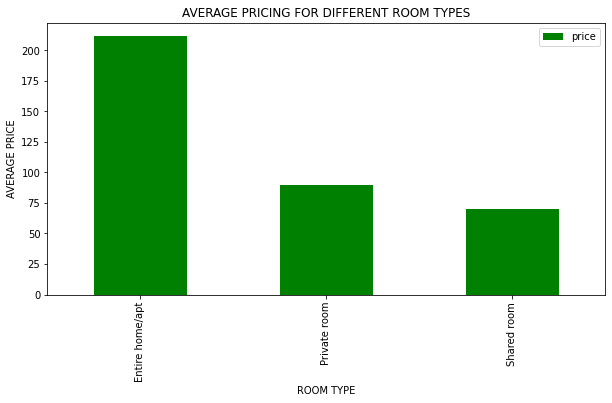

In [45]:
pd.DataFrame(airbnb_df.groupby(['room_type'])['price'].mean()).plot.bar(color ='g', figsize=(10,5))
plt.xlabel('ROOM TYPE')
plt.ylabel('AVERAGE PRICE')
plt.title('AVERAGE PRICING FOR DIFFERENT ROOM TYPES')
plt.show()

We can clearly see the average price for a Entire home/apt is much higher than any other room types whereas the average price for shared room is very low. which seems obvious, as the entire home/ apt tend to have higher pricing than a shared  room.

In [46]:
airbnb_df.groupby(['room_type','neighbourhood_group'])['price'].mean()

room_type        neighbourhood_group
Entire home/apt  Bronx                  127.506596
                 Brooklyn               178.327545
                 Manhattan              249.239109
                 Queens                 147.050573
                 Staten Island          173.846591
Private room     Bronx                   66.788344
                 Brooklyn                76.500099
                 Manhattan              116.776622
                 Queens                  71.762456
                 Staten Island           62.292553
Shared room      Bronx                   59.800000
                 Brooklyn                50.527845
                 Manhattan               88.977083
                 Queens                  69.020202
                 Staten Island           57.444444
Name: price, dtype: float64

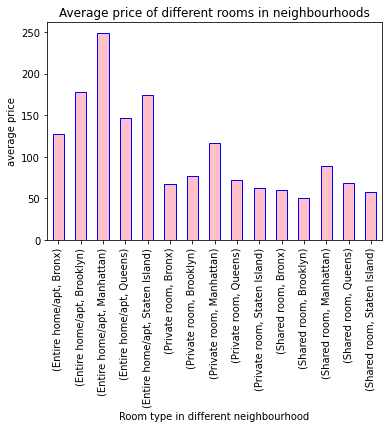

In [47]:
airbnb_df.groupby(['room_type','neighbourhood_group'])['price'].mean().plot(kind='bar',color='pink',edgecolor='blue')
plt.xlabel('Room type in different neighbourhood')
plt.ylabel('average price')
plt.title('Average price of different rooms in neighbourhoods')
plt.show()

**From the above plot we can say**

*   The average price of Entire room/apt in manhattan is higher than any other in neighbourhood
*   The average price of shared room in manhatten is is higher than any other neighbourhoods 


*   The average price of shared room in manhattan is higher than any other neighbourhood

**From the above insights we can conclude that the manhattan is a expensive place to rent property in any category**





In [48]:
top_reviewed_listings=airbnb_df.nlargest(10,'number_of_reviews')
top_reviewed_listings

,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
11759,47621202,Dona,Queens,Jamaica,40.66730,-73.76831,Private room,47,1,629,14.58,2,333
2031,4734398,Jj,Manhattan,Harlem,40.82085,-73.94025,Private room,49,1,607,7.75,3,293
2030,4734398,Jj,Manhattan,Harlem,40.82124,-73.93838,Private room,49,1,597,7.72,3,342
2015,4734398,Jj,Manhattan,Harlem,40.82264,-73.94041,Private room,49,1,594,7.57,3,339
13495,47621202,Dona,Queens,Jamaica,40.66939,-73.76975,Private room,47,1,576,13.40,2,173
10623,37312959,Maya,Queens,East Elmhurst,40.77006,-73.87683,Private room,46,1,543,11.59,5,163
1879,2369681,Carol,Manhattan,Lower East Side,40.71921,-73.99116,Private room,99,2,540,6.95,1,179
20403,26432133,Danielle,Queens,East Elmhurst,40.76335,-73.87007,Private room,48,1,510,16.22,5,341
4870,12949460,Asa,Brooklyn,Park Slope,40.67926,-73.97711,Entire home/apt,160,1,488,8.14,1,269
471,792159,Wanda,Brooklyn,Bushwick,40.70283,-73.92131,Private room,60,3,480,6.70,1,0


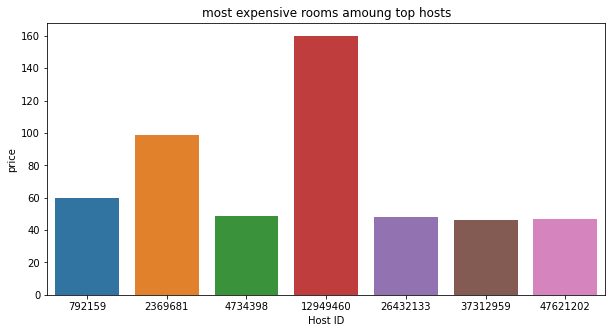

In [49]:
plt.figure(figsize=(10,5))
sns.barplot(x='host_id',y='price',data=top_reviewed_listings)
plt.xlabel("Host ID")
plt.ylabel("price")
plt.title("most expensive rooms amoung top hosts")
plt.show()


The host with ``host_id`` **12949460** list's most expensive room

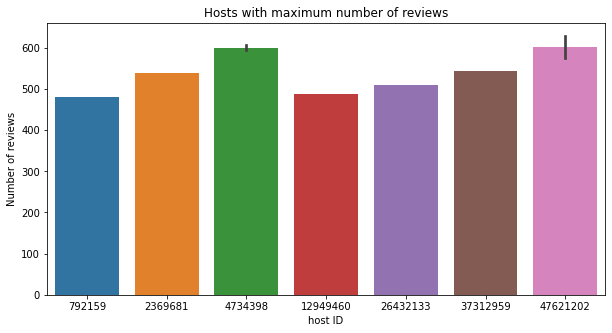

In [50]:
plt.figure(figsize=(10,5))
sns.barplot(x='host_id',y='number_of_reviews',data=top_reviewed_listings)
plt.xlabel("host ID")
plt.ylabel('Number of reviews')
plt.title("Hosts with maximum number of reviews")
plt.show()

In [51]:
pd.pivot_table(airbnb_df[['room_type']],index=airbnb_df['neighbourhood_group'],columns=airbnb_df['room_type'],aggfunc='count')

room_type                         
room_type           Entire home/apt Private room Shared room
neighbourhood_group                                         
Bronx                           379          652          60
Brooklyn                       9559        10132         413
Manhattan                     13199         7982         480
Queens                         2096         3372         198
Staten Island                   176          188           9

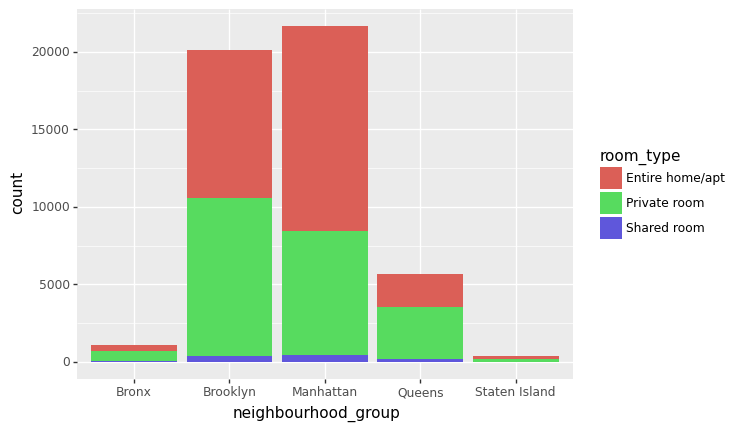

<ggplot: (8728743557693)>

In [52]:
ggplot(airbnb_df)+aes('neighbourhood_group',fill='room_type')+geom_bar()

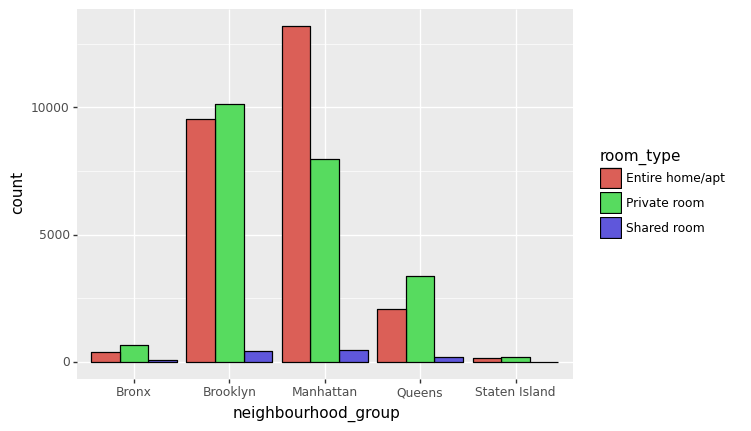

<ggplot: (8728743495509)>

In [53]:
ggplot(airbnb_df)+aes('neighbourhood_group',fill='room_type')+geom_bar(position = position_dodge(),colour="black")

**From the above plot we can draw following  insights**


*   In manhattan the number of listed  Entire home/apt is much higher than any other ``room type``
*   In ``Brooklyn`` the number of listed ``Private room`` is slightly higher than ``Entire home/apt``


*   In ``Queens`` the total number of listed ``Private Rooms``  is much higher than the anyother room type.
*  In ``Bronx`` and ``Staten island`` the number of rooms in all the category are almost same



**From the above insights we can conclude that the people prefer to live in Entire home/apt in Mahanttan** 




In [54]:
boroughs = gpd.read_file(geoplot.datasets.get_path('nyc_boroughs'))
geo_df=gpd.GeoDataFrame(airbnb_df,geometry=gpd.points_from_xy(airbnb_df["longitude"], airbnb_df["latitude"]))

No handles with labels found to put in legend.


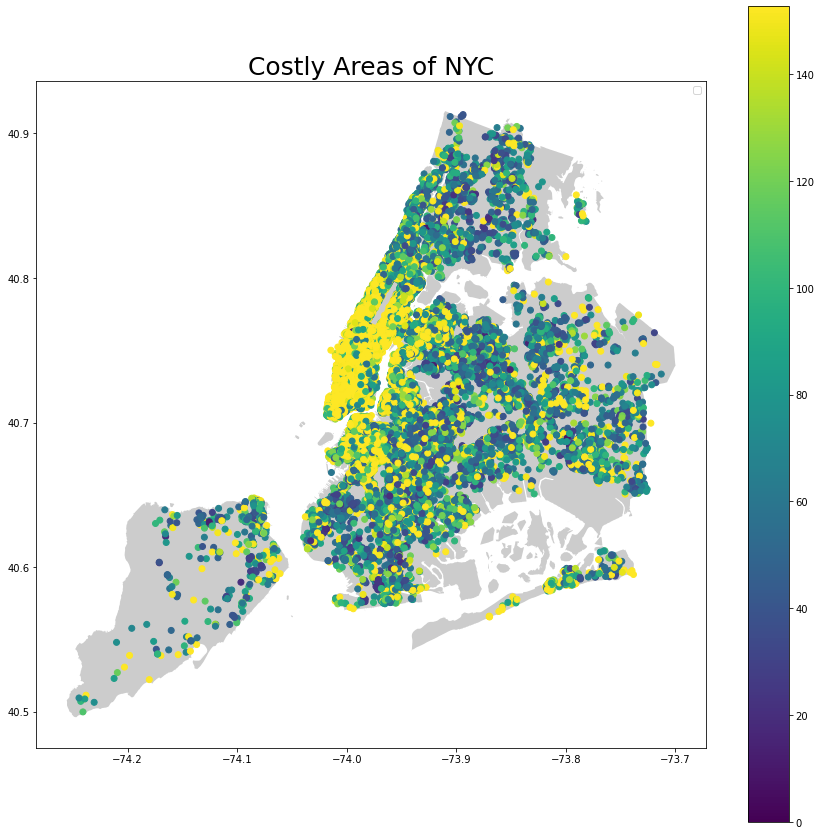

In [55]:
fig,ax=plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax,alpha=0.4,color="grey")
x, y = geo_df['longitude'].values, geo_df['latitude'].values
plt.scatter(x,y,c=geo_df['price'])
plt.clim(0,np.mean(airbnb_df['price']))
plt.title("Costly Areas of NYC",fontdict={'fontsize':25})
plt.colorbar()
plt.legend()



1.   Yellow dots represents the places where the properties are costly
2.   blue dots reprensts the places where the properties are comparatively cheaper
**The place where we can see high concentration of yellow dots is the most costly region in NYC**



No handles with labels found to put in legend.


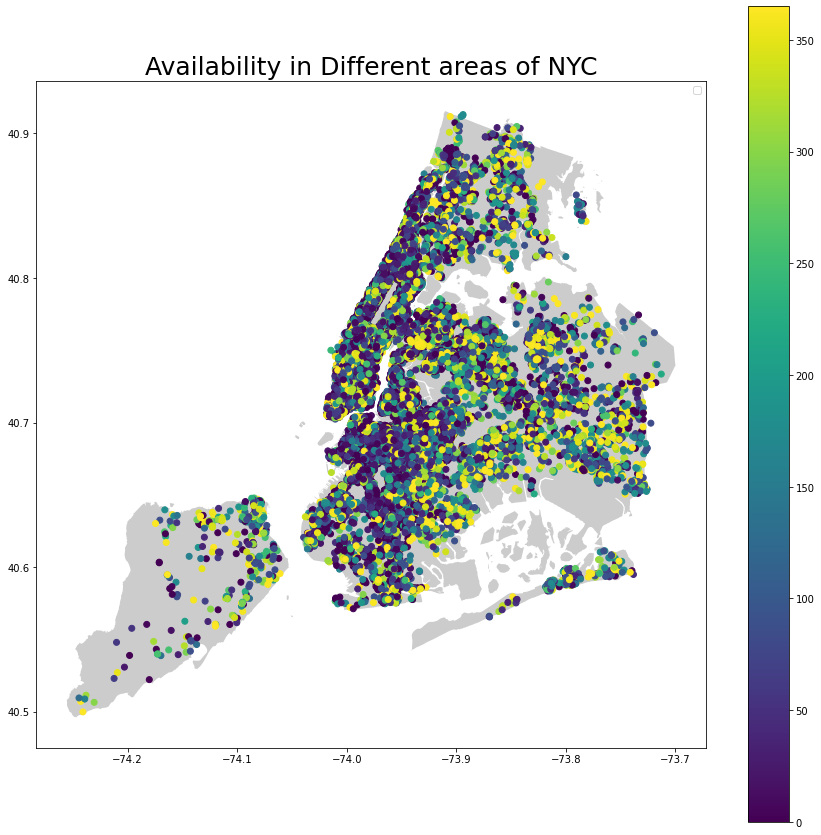

In [56]:
fig,ax=plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax,alpha=0.4,color="grey")
x, y = geo_df['longitude'].values, geo_df['latitude'].values
plt.scatter(x,y,c=geo_df['availability_365'])
plt.clim(0,np.max(geo_df['availability_365']))
plt.title('Availability in Different areas of NYC',fontdict={'fontsize':25})
plt.colorbar()
plt.legend()



1.   From the above graph we can say people prefer to rent a room which have less minmum number of nights
2.   If we compare above two graphs we can conclude the region with most expensive rooms have less number of minumn nights to stay.



## **Conclusion**

In  the data analysis project, I analyzed some of the most popular trends given the Airbnb's data on listings in NYC

Summarizing findings:-

*   **Manhattan** and **Brooklyn** are the prime locations with highest number of rooms.

*   **Manhattan** is the most expensive place to live.

*   In **Manhattan** people perfer to rent entire home and apartment.

*   **Staten island** is the least popular place amoung them.

*   Most properties have price in the range **0-150**

*   **Prices** very wildly based on property and room types.

*  Majority of Hosts listed their entire home property 

*   People prefer to list there properties for minimun number of nights **less than a week** .

*   The properties which are **expensive** tend to attract **less reviews**, which means people less likely to rent expensive rooms















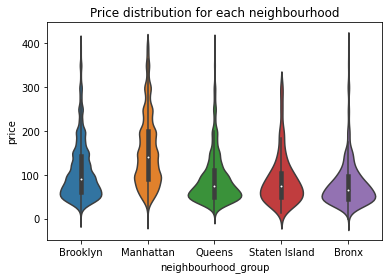

In [60]:
# creating a sub-dataframe values less than 400
adjusted_airbnb_df =airbnb_df[airbnb_df.price < 400]

# using violinplot to showcase density and distribtuion of prices 
sns.violinplot(data=adjusted_airbnb_df, x='neighbourhood_group', y='price')
plt.title('Price distribution for each neighbourhood')
plt.show()
